In [260]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import sparse

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [261]:
# Discretize the dimensions to simplify the following simulations
# More points gives a better simulation but will require more computation

NUM_DIMENSIONS = 2
POINTS_PER_DIMENSION = 200

def createNDimensionalMeshGrid(dimensionLimits: tuple[int, int],):
    return np.meshgrid(*[np.linspace(dimensionLimits[0], dimensionLimits[1], POINTS_PER_DIMENSION) for _ in range(NUM_DIMENSIONS)])

X, Y = createNDimensionalMeshGrid([-3,3])

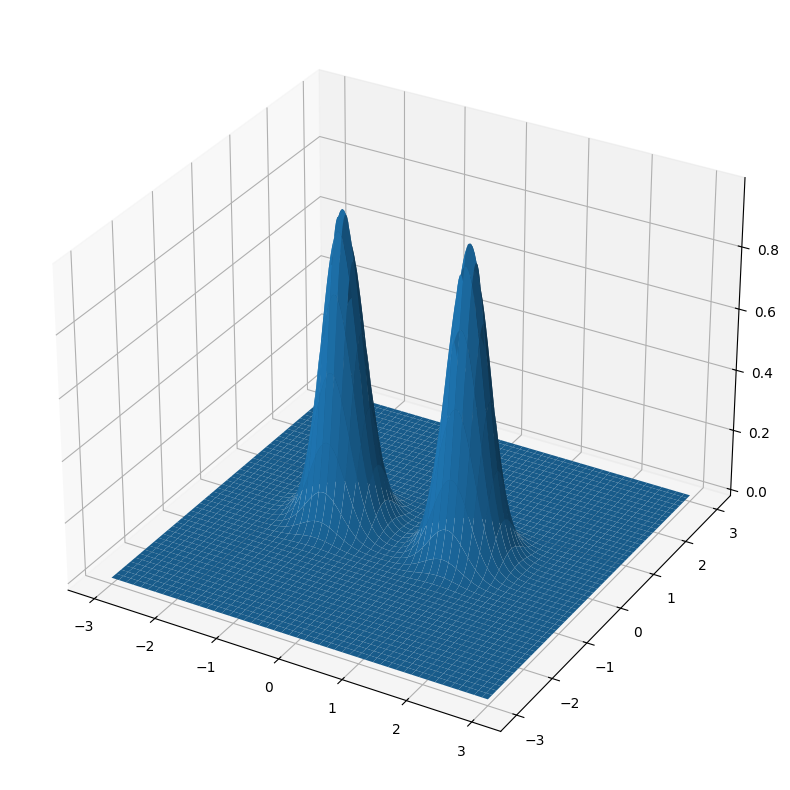

In [262]:
# Potential is a function over the entire space that determines the potential energy of a particle at that position
# Negative potentials will act as attractors, and positive potentials will act as repellors

def gaussian(xPos, xWidth, yPos, yWidth):
    return lambda x,y: np.exp(-(x-xPos)**2 / (2*xWidth**2)) * np.exp(-(y-yPos)**2 / (2*yWidth**2))

def potential(x,y):
    STD = 0.3
    leftGaussian = gaussian(-1,STD,0,STD)
    rightGaussian = gaussian(1,STD,0,STD)
    return + (leftGaussian(x,y) + rightGaussian(x,y))

V = potential(X,Y)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, V)
plt.show()

In [263]:
# We will approximate the Hamiltonian, mainly by replacing partial derivatives in each dimension (a continuous effect) with matrices
# The approximation of the second derivative is just a matrix D, of dimension pointsPerDimension**2 with -2 on the main diagonal and 1 on the first off-diagonal
# We approximate the sum of second partials by taking the Kronecker product of these matrices

def getSecondPartialMatrixApproximation():
    onesArray = np.ones([POINTS_PER_DIMENSION])
    diagonalEntries = np.array([onesArray, -2*onesArray, onesArray])
    return sparse.spdiags(diagonalEntries, np.array([-1,0,1]), POINTS_PER_DIMENSION, POINTS_PER_DIMENSION)

In [264]:
# Finally, the Schrodinger equation is just the kinetic energy plus potential energy, T+U
# Where T is -0.5 * DxD, U=m * DelX * V (here, DelX is our spacing in each dimension, and m is the particle mass)

def getKineticSchrodingerTerm():
    D = getSecondPartialMatrixApproximation()
    finalMatrix = D

    for _ in range(NUM_DIMENSIONS-1):
        finalMatrix = sparse.kronsum(finalMatrix, D)
    
    return -1/2 * finalMatrix

T = getKineticSchrodingerTerm()
U = sparse.diags(V.reshape(POINTS_PER_DIMENSION**2), (0))

H = T+U

In [265]:
# Getting this onto the GPU is a little convoluted, we have to parse H into TOCOO format, so pytorch can handle it as a sparse matrix

H = H.tocoo()
H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device)

In [266]:
# Okay, all set! Time to solve for eigenvectors (wavefunctions of particles in this space) and eigenvalues (energies of those wavefunctions)
# We want the *lowest* energy states

eigenvalues, eigenvectors = torch.lobpcg(H, k=10, largest=False)

def getEigenIndex(index: int):
    return (eigenvalues[index], eigenvectors.T[index].reshape(POINTS_PER_DIMENSION, POINTS_PER_DIMENSION).cpu())

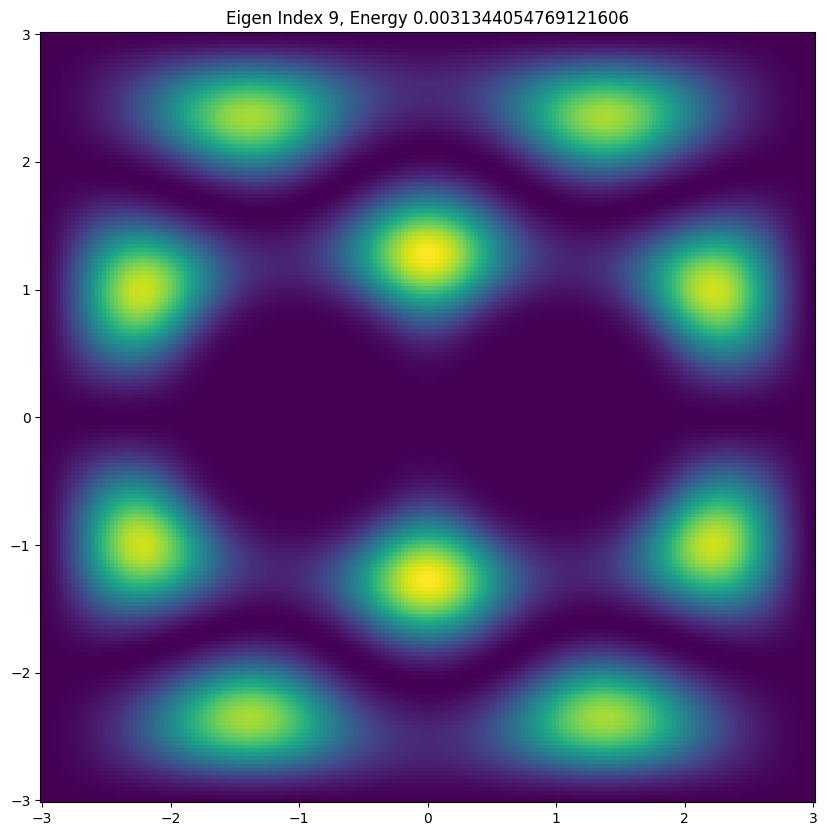

In [267]:
targetIndex = 9
eigenvalue, eigenvector = getEigenIndex(targetIndex)

plt.figure(figsize=(10,10))
plt.pcolormesh(X, Y, eigenvector**2)
plt.title(f"Eigen Index {targetIndex}, Energy {eigenvalue}")
plt.show()